### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'covid_trials',
    'source': 'kaggle', # ['kaggle', 'local', 'openml', 'hf']
    'remote_path': 'parulpandey/covid19-clinical-trials-dataset',
    'files': ['COVID clinical trials.csv'],
    'rename_files': ['covid_trials_data.csv'],
    'task': 'reg', # ['reg', 'clf']
    'target': 'days_to_complete',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset not downloaded yet. Downloading to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/covid_trials.
Info: Downloaded: COVID clinical trials.csv from Kaggle to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/covid_trials.
Info: Unzipped the file '/media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/covid_trials/COVID%20clinical%20trials.csv.zip'.
Info: No unlisted files found in /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/covid_trials.
Info: Renamed COVID clinical trials.csv to covid_trials_data.csv.
Downloaded covid_trials dataset to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/covid_trials


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/covid_trials/covid_trials_data.csv


,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04785898,Diagnostic Performance of the ID Now™ COVID-19...,COVID-IDNow,"Active, not recruiting",No Results Available,Covid19,Diagnostic Test: ID Now™ COVID-19 Screening Test,Evaluate the diagnostic performance of the ID ...,Groupe Hospitalier Paris Saint Joseph,All,"18 Years and older (Adult, Older Adult)",Not Applicable,1000.0,Other,Interventional,Allocation: N/A|Intervention Model: Single Gro...,COVID-IDNow,"November 9, 2020","December 22, 2020","April 30, 2021","March 8, 2021",NaN,"March 8, 2021","Groupe Hospitalier Paris Saint-Joseph, Paris, ...",NaN,https://ClinicalTrials.gov/show/NCT04785898
1,2,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,COVID-19,Not yet recruiting,No Results Available,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,60.0,Other,Interventional,Allocation: Randomized|Intervention Model: Par...,COVID19-0001-USR,"November 2, 2020","December 15, 2020","January 29, 2021","October 20, 2020",NaN,"October 20, 2020","Cimedical, Barranquilla, Atlantico, Colombia",NaN,https://ClinicalTrials.gov/show/NCT04595136
2,3,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,TAC-COVID19,Recruiting,No Results Available,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,All,"18 Years and older (Adult, Older Adult)",NaN,500.0,Other,Observational,Observational Model: Cohort|Time Perspective: ...,TAC-COVID19,"May 7, 2020","June 15, 2021","June 15, 2021","May 20, 2020",NaN,"November 9, 2020","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...",NaN,https://ClinicalTrials.gov/show/NCT04395482


In [6]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.5 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    # df_file = df_file[df_file[dataset_config['target']].notna()] $ TODO: the target column is not in the dataset yet
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index(['Acronym', 'Results First Posted', 'Study Documents'], dtype='object')
Dataframe shape before/afrer cleaning: (5783, 27) / (5783, 24)


In [7]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['Rank', 'NCT Number', 'First Posted', 'URL', 'Last Update Posted', 'Primary Completion Date',
                'Other IDs', 'Founded Bys', 'Study Results'] # Study Results are post outcome data - leaks future

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape

    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

dataset_files_cleaned[0].head(n=3)

Column Founded Bys not found in dataframe
Dataframe shape before/afrer by-hand cleaning: (5783, 24) / (5783, 16)


,Title,Status,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Start Date,Completion Date,Locations
0,Diagnostic Performance of the ID Now™ COVID-19...,"Active, not recruiting",Covid19,Diagnostic Test: ID Now™ COVID-19 Screening Test,Evaluate the diagnostic performance of the ID ...,Groupe Hospitalier Paris Saint Joseph,All,"18 Years and older (Adult, Older Adult)",Not Applicable,1000.0,Other,Interventional,Allocation: N/A|Intervention Model: Single Gro...,"November 9, 2020","April 30, 2021","Groupe Hospitalier Paris Saint-Joseph, Paris, ..."
1,Study to Evaluate the Efficacy of COVID19-0001...,Not yet recruiting,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,60.0,Other,Interventional,Allocation: Randomized|Intervention Model: Par...,"November 2, 2020","January 29, 2021","Cimedical, Barranquilla, Atlantico, Colombia"
2,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,Recruiting,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,All,"18 Years and older (Adult, Older Adult)",NaN,500.0,Other,Observational,Observational Model: Cohort|Time Perspective: ...,"May 7, 2020","June 15, 2021","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P..."


In [8]:
# check what are the status values in the dataset -> we should only keep those concluded
unique_status_values = dataset_files_cleaned[0]['Status'].unique()
print("Unique status values:")
for status in unique_status_values:
    print(status)

Unique status values:
Active, not recruiting
Not yet recruiting
Recruiting
Enrolling by invitation
Suspended
Completed
Withdrawn
Terminated
No longer available
Available
Approved for marketing
Temporarily not available


In [9]:
import copy 
import numpy as np
import pandas as pd

tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

# Define sanity thresholds
MAX_REASONABLE_DAYS = 365 * 10  # 10 years

# Define valid statuses that imply study is finished
valid_statuses = ['Completed', 'Withdrawn', 'Terminated', 'Approved for marketing']

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")

    # 1. Filter to only studies with a final status
    df_file = df_file[df_file['Status'].isin(valid_statuses)].copy()

    # 2. Parse dates
    start_date = pd.to_datetime(df_file['Start Date'], errors='coerce')
    completion_date = pd.to_datetime(df_file['Completion Date'], errors='coerce')

    # 3. Compute target duration in days
    target_days = (completion_date - start_date).dt.days

    # 4. Add target column to df_file
    df_file[dataset_config['target']] = target_days

    # 5. Drop rows with:
    #    - NaN target
    #    - Negative target (Completion before Start)
    #    - Unreasonably large durations (> 10 years)
    df_file = df_file[
        df_file[dataset_config['target']].notna() &
        (df_file[dataset_config['target']] >= 0) &
        (df_file[dataset_config['target']] <= MAX_REASONABLE_DAYS)
    ].copy()

    # 6. Drop 'Completion Date'
    df_file.drop(['Completion Date'], axis=1, inplace=True)

    # 7. Convert 'Start Date' to UNIX timestamp (only for kept rows)
    df_file['Start Date'] = start_date.loc[df_file.index].apply(
        lambda x: x.timestamp() if pd.notnull(x) else np.nan
    )

    print(f"Dataframe shape after custom cleaning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# reset dataset_files_cleaned to pre-cleaned version (for next cells)
dataset_files_cleaned = tmp_df


Dataframe shape before custom cleaning: (5783, 16)
Dataframe shape after custom cleaning: (1165, 16)


### Now it is time to visualize our changes

In [10]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,Title,Status,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Start Date,Locations,days_to_complete
13,Smell and Taste Disorders in COVID-19 Patients,Completed,covid19,Other: Investigation of smell and taste disorders,Identification of demographic and clinical fac...,University of Milano Bicocca,All,"18 Years and older (Adult, Older Adult)",NaN,376.0,Other,Observational,Observational Model: Cohort|Time Perspective: ...,1.591834e+09,"ASST Monza-Ospedale San Gerardo, Monza, Italy",127.0
16,Diagnostic Performance Evaluation of a Novel S...,Completed,Covid19|SARS-CoV-2 Infection,Diagnostic Test: RT-qPCR test|Diagnostic Test:...,Evaluation of COVID VIRO® diagnostic specifici...,Centre Hospitalier Régional d'Orléans,All,"18 Years and older (Adult, Older Adult)",Not Applicable,200.0,Other,Interventional,Allocation: N/A|Intervention Model: Single Gro...,1.602547e+09,"Centre Hospitalier Régional d'Orléans, France,...",4.0
21,Study Evaluating the Safety and Efficacy of Au...,Completed,Coronavirus Disease 2019 (COVID-19),Biological: Autologous Non-Hematopoietic Perip...,Adverse reactions incidence.|Rate of mortality...,Abu Dhabi Stem Cells Center,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,146.0,Other,Interventional,Allocation: Randomized|Intervention Model: Par...,1.585958e+09,"Abu Dhabi Stem Cells Center, Abu Dhabi, United...",101.0


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [11]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (3): ['Enrollment', 'Start Date', 'days_to_complete']
Categorical columns (5): ['Status', 'Gender', 'Phases', 'Funded Bys', 'Study Type']
Textual columns (8): ['Title', 'Conditions', 'Interventions', 'Outcome Measures', 'Sponsor/Collaborators', 'Age', 'Study Designs', 'Locations']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [12]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

pd.set_option('display.max_rows', None)
display(summary_df)  # Or print(summary_df)

,Column Name,Example Value,Type,# Categories
0,Title,Smell and Taste Disorders in COVID-19 Patients,textual,1164
1,Status,Completed,categorical,3
2,Conditions,covid19,textual,722
3,Interventions,Other: Investigation of smell and taste disorders,textual,904
4,Outcome Measures,Identification of demographic and clinical fac...,textual,1157
5,Sponsor/Collaborators,University of Milano Bicocca,textual,854
6,Gender,All,categorical,3
7,Age,"18 Years and older (Adult, Older Adult)",textual,153
8,Phases,Not Applicable,categorical,8
9,Enrollment,376.0,numerical,~ 496 ~


### Saving the processed data and loading it back up

In [18]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{dataset_config['dataset_name']}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping save.")
        continue

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/covid_trials/covid_trials_processed.pkl


In [19]:
import os
import pandas as pd

import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( "..", "..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from configs.dataset_configs import get_a_dataset_dict

print(dataset_config['dataset_name'])

loaded_dataset_config = get_a_dataset_dict(dataset_config['dataset_name'])

file_base = loaded_dataset_config['name']
processed_filename = f"{file_base}_processed.pkl"
processed_path = os.path.join(download_path, processed_filename)

# Load the bundled dictionary (data + summary + config)
bundle = pd.read_pickle(processed_path)

# Extract components
loaded_df = bundle['data']
summary_df = bundle['summary']
loaded_config = bundle['config']

print(f"\n=== {file_base.upper()} ===")
print(f"Loaded config keys: {list(loaded_config.keys())}")

# Show metadata
meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
display(meta_df)

# Flatten for modeling
loaded_df.columns = loaded_df.columns.get_level_values(0)
display(loaded_df.head(n=3))


covid_trials

=== COVID_TRIALS ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Title,textual,1164
1,Status,categorical,3
2,Conditions,textual,722
3,Interventions,textual,904
4,Outcome Measures,textual,1157
5,Sponsor/Collaborators,textual,854
6,Gender,categorical,3
7,Age,textual,153
8,Phases,categorical,8
9,Enrollment,numerical,~ 496 ~


Column Name,Title,Status,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Start Date,Locations,days_to_complete
13,Smell and Taste Disorders in COVID-19 Patients,Completed,covid19,Other: Investigation of smell and taste disorders,Identification of demographic and clinical fac...,University of Milano Bicocca,All,"18 Years and older (Adult, Older Adult)",NaN,376.0,Other,Observational,Observational Model: Cohort|Time Perspective: ...,1.591834e+09,"ASST Monza-Ospedale San Gerardo, Monza, Italy",127.0
16,Diagnostic Performance Evaluation of a Novel S...,Completed,Covid19|SARS-CoV-2 Infection,Diagnostic Test: RT-qPCR test|Diagnostic Test:...,Evaluation of COVID VIRO® diagnostic specifici...,Centre Hospitalier Régional d'Orléans,All,"18 Years and older (Adult, Older Adult)",Not Applicable,200.0,Other,Interventional,Allocation: N/A|Intervention Model: Single Gro...,1.602547e+09,"Centre Hospitalier Régional d'Orléans, France,...",4.0
21,Study Evaluating the Safety and Efficacy of Au...,Completed,Coronavirus Disease 2019 (COVID-19),Biological: Autologous Non-Hematopoietic Perip...,Adverse reactions incidence.|Rate of mortality...,Abu Dhabi Stem Cells Center,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,146.0,Other,Interventional,Allocation: Randomized|Intervention Model: Par...,1.585958e+09,"Abu Dhabi Stem Cells Center, Abu Dhabi, United...",101.0


### Bonus insights (Regression)

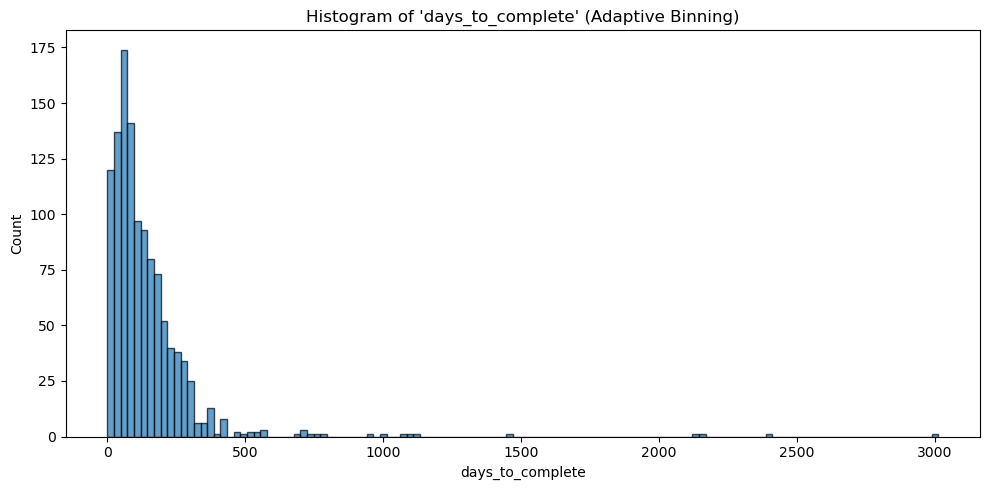

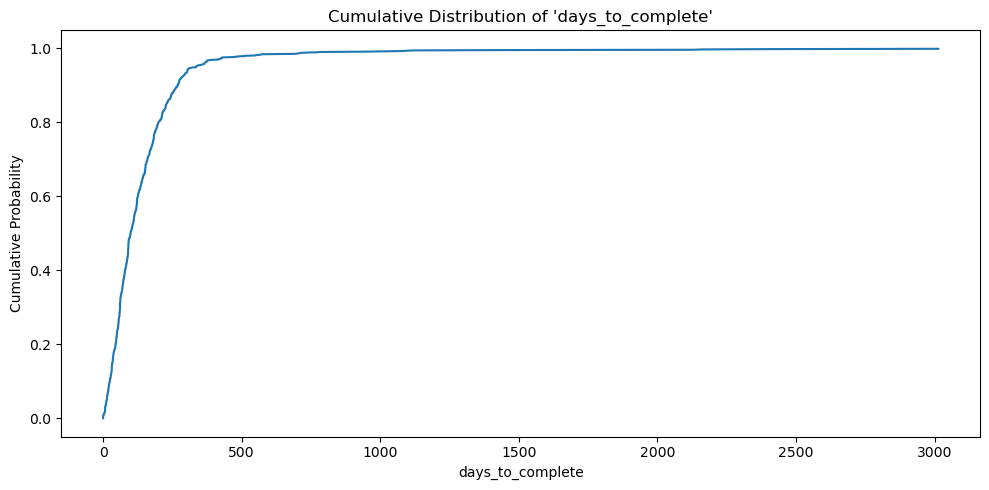

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get target series
target_series = loaded_df[dataset_config['target']]

# 1️⃣ Histogram with Freedman-Diaconis rule for binning
q25, q75 = np.percentile(target_series, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(target_series) ** (-1/3)
bin_count = int((target_series.max() - target_series.min()) / bin_width)
bin_count = max(10, bin_count)  # Ensure reasonable minimum bin count

plt.figure(figsize=(10, 5))
plt.hist(target_series, bins=bin_count, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2️⃣ Cumulative Distribution Function (CDF)
target_sorted = target_series.sort_values()
cdf = np.arange(len(target_sorted)) / len(target_sorted)

plt.figure(figsize=(10, 5))
plt.plot(target_sorted, cdf, color='tab:blue')
plt.title(f"Cumulative Distribution of '{dataset_config['target']}'")
plt.xlabel(dataset_config['target'])
plt.ylabel('Cumulative Probability')
plt.tight_layout()
plt.show()

